## **DS1**

Cell 1: Installing SMOTE incase the dataset is imbalance.

Loading and preprocessing data...

Dataset Info:
Shape: (70, 8)
Time range: 2014-01-31 00:00:00 to 2019-10-31 00:00:00
Number of months: 70

Missing values per column:
M01AB    0
M01AE    0
N02BA    0
N02BE    0
N05B     0
N05C     0
R03      0
R06      0
dtype: int64

Outliers detected: 4 rows


<ipython-input-14-0120d92b91fb>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datum'] = pd.to_datetime(df['datum'], dayfirst=True)


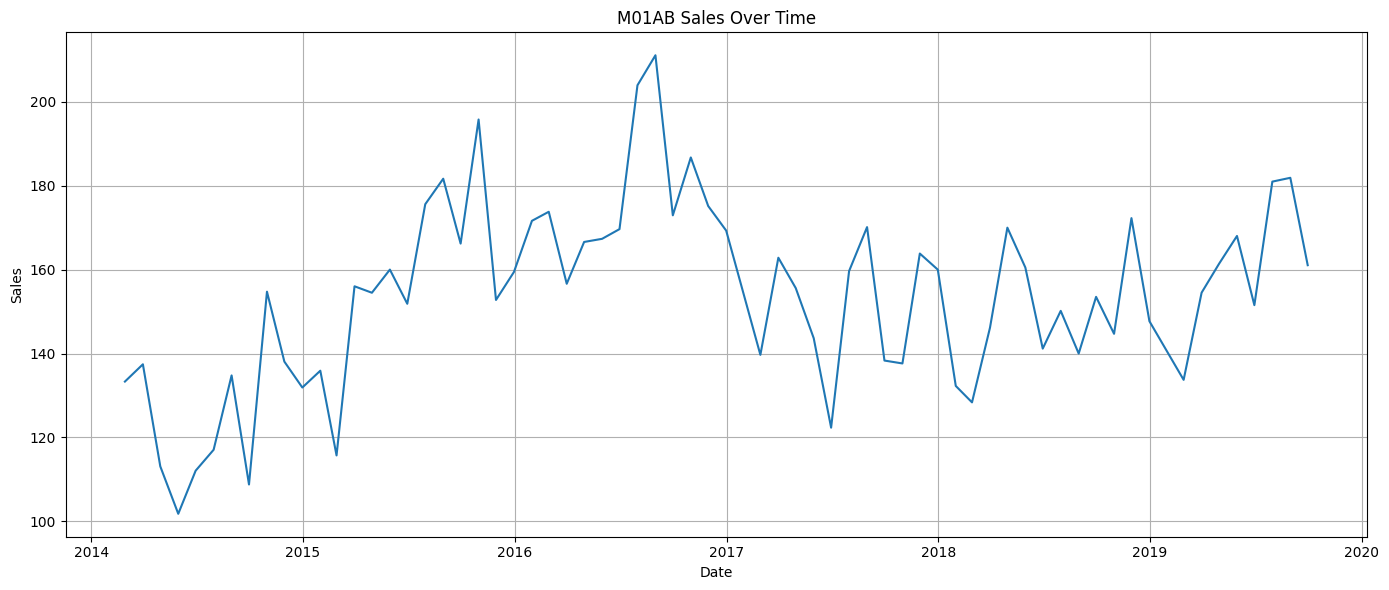


Descriptive statistics for M01AB:
count     66.000000
mean     153.752727
std       22.338129
min      101.790000
25%      138.142500
50%      155.180000
75%      169.000000
max      211.130000
Name: M01AB, dtype: float64


In [ ]:
# Cell 1: Data Preprocessing and Exploratory Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# Load data
print("Loading and preprocessing data...")
df = pd.read_csv("salesmonthly.csv")
df['datum'] = pd.to_datetime(df['datum'], dayfirst=True)
df.set_index('datum', inplace=True)

# Basic info
print("\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"Time range: {df.index.min()} to {df.index.max()}")
print(f"Number of months: {len(df)}")

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Fill missing values
df.fillna(df.mean(), inplace=True)

# Check for outliers using Z-score
z_scores = np.abs(zscore(df))
outliers = (z_scores > 3).any(axis=1)
print(f"\nOutliers detected: {outliers.sum()} rows")

# Scaling for clustering
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df),
                         columns=df.columns,
                         index=df.index)

# Visualize data
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['M01AB'])
plt.title('M01AB Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nDescriptive statistics for M01AB:")
print(df['M01AB'].describe())

Cell 2 : Importing libraries

Performing unsupervised learning with KMeans and DBSCAN...
KMeans: Silhouette=0.218, Davies-Bouldin=1.512
DBSCAN: Validation metrics unavailable (not enough clusters or noise points)


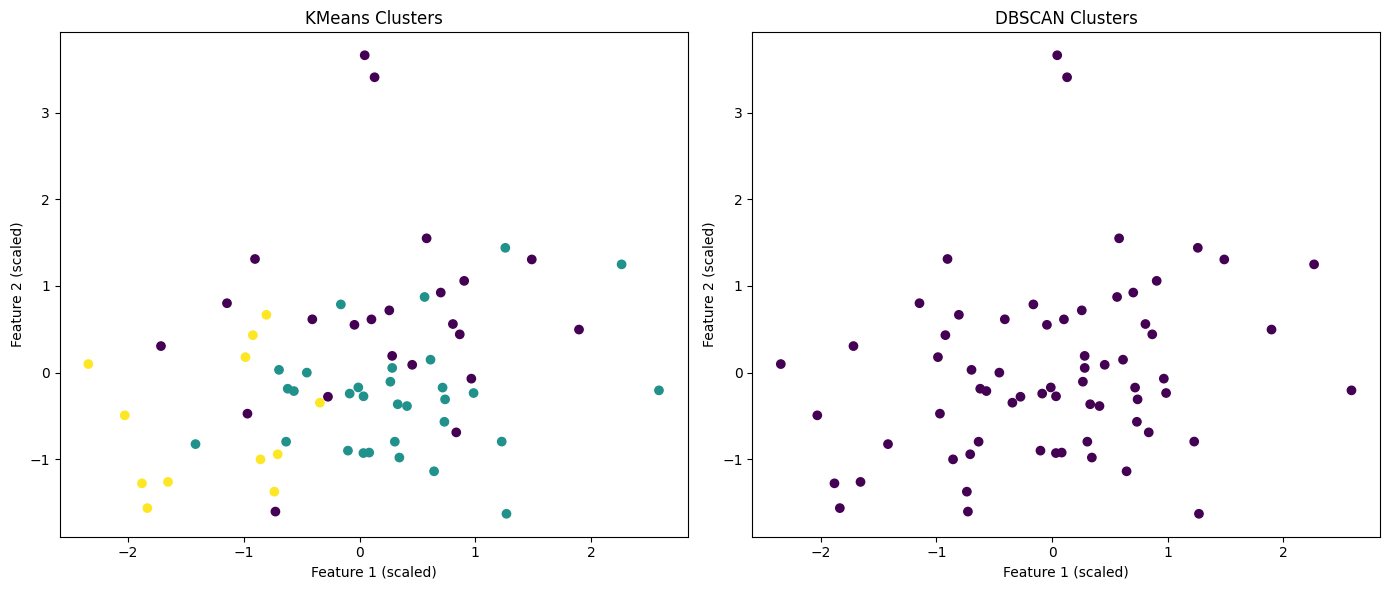

In [ ]:
# Cell 2: Unsupervised Learning (with clustering validation)

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

print("Performing unsupervised learning with KMeans and DBSCAN...")

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)
sil_kmeans = silhouette_score(df_scaled, kmeans_labels)
db_kmeans = davies_bouldin_score(df_scaled, kmeans_labels)
print(f"KMeans: Silhouette={sil_kmeans:.3f}, Davies-Bouldin={db_kmeans:.3f}")

# DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)
if len(set(dbscan_labels)) > 1 and -1 not in dbscan_labels:
    sil_dbscan = silhouette_score(df_scaled, dbscan_labels)
    db_dbscan = davies_bouldin_score(df_scaled, dbscan_labels)
    print(f"DBSCAN: Silhouette={sil_dbscan:.3f}, Davies-Bouldin={db_dbscan:.3f}")
else:
    print("DBSCAN: Validation metrics unavailable (not enough clusters or noise points)")

# Visualize clusters
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('KMeans Clusters')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')

plt.subplot(1, 2, 2)
plt.scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clusters')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')

plt.tight_layout()
plt.show()


Cell 3 : Load and Preprocess Dataset

Performing feature selection...
Top features by ANOVA F-value: ['M01AB', 'N02BA', 'N05B', 'R03', 'R06']
Top features by Mutual Information: ['M01AB', 'M01AE', 'N02BA', 'N05B', 'R06']


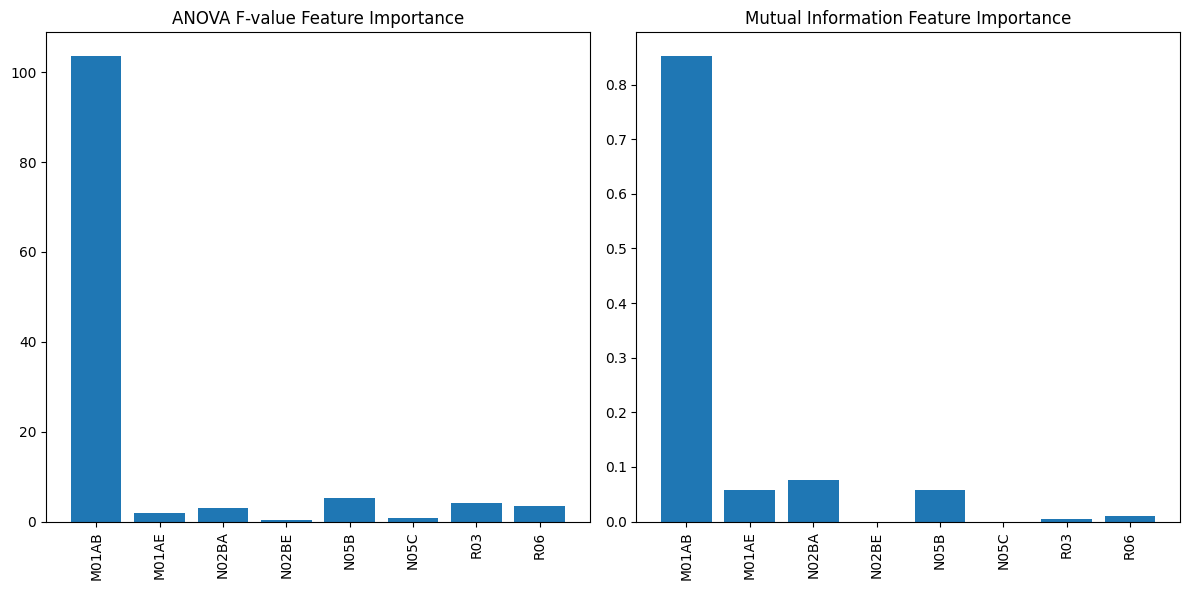


Selected features for further analysis: ['M01AB', 'N02BA', 'N05B', 'R03', 'R06']


In [ ]:
# Cell 3: Feature Selection

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import matplotlib.pyplot as plt
import numpy as np

print("Performing feature selection...")

# For demonstration, bin the target (M01AB) for classification
df_fs = df.copy()
df_fs['target'] = pd.cut(df_fs['M01AB'], bins=3, labels=[0, 1, 2])
X = df_fs.drop('target', axis=1)
y = df_fs['target']

# Technique 1: ANOVA F-value
selector_f = SelectKBest(score_func=f_classif, k=5)
X_f = selector_f.fit_transform(X, y)
features_f = X.columns[selector_f.get_support()]
f_scores = selector_f.scores_
print("Top features by ANOVA F-value:", list(features_f))

# Technique 2: Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=5)
X_mi = selector_mi.fit_transform(X, y)
features_mi = X.columns[selector_mi.get_support()]
mi_scores = selector_mi.scores_
print("Top features by Mutual Information:", list(features_mi))

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(X.columns, f_scores)
plt.title('ANOVA F-value Feature Importance')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.bar(X.columns, mi_scores)
plt.title('Mutual Information Feature Importance')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Use ANOVA-selected features for further steps
df_selected = df_fs[list(features_f) + ['target']]
print("\nSelected features for further analysis:", list(features_f))

Cell 4 : Normalize and Apply Clustering (Unsupervised Learning)

Handling class imbalance...
Original class distribution: [17 40  9]
After SMOTE: [32 32 32]
After RandomOverSampler: [32 32 32]


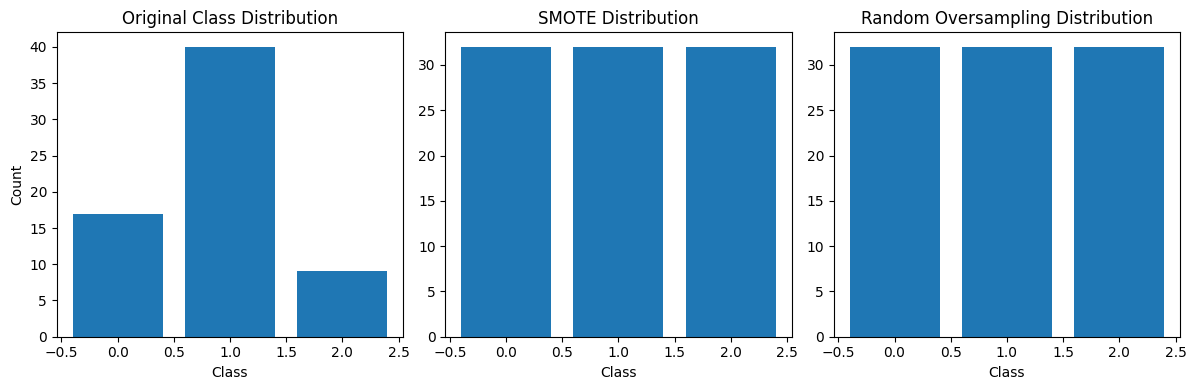

In [ ]:
# Cell 4: Imbalance Learning

from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

print("Handling class imbalance...")

X = df_selected.drop("target", axis=1)
y = df_selected["target"]

# Check class distribution
class_counts = np.bincount(y.astype(int))
print("Original class distribution:", class_counts)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Technique 1: SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
smote_counts = np.bincount(y_train_sm.astype(int))
print("After SMOTE:", smote_counts)

# Technique 2: RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
ros_counts = np.bincount(y_train_ros.astype(int))
print("After RandomOverSampler:", ros_counts)

# Visualize class distributions
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.bar(range(len(class_counts)), class_counts)
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.bar(range(len(smote_counts)), smote_counts)
plt.title('SMOTE Distribution')
plt.xlabel('Class')

plt.subplot(1, 3, 3)
plt.bar(range(len(ros_counts)), ros_counts)
plt.title('Random Oversampling Distribution')
plt.xlabel('Class')

plt.tight_layout()
plt.show()

Cell 5 : Feature Selection Setup

Training set: 54 months (2014-02-28 00:00:00 to 2018-08-31 00:00:00)
Test set: 12 months (2018-09-30 00:00:00 to 2019-09-30 00:00:00)


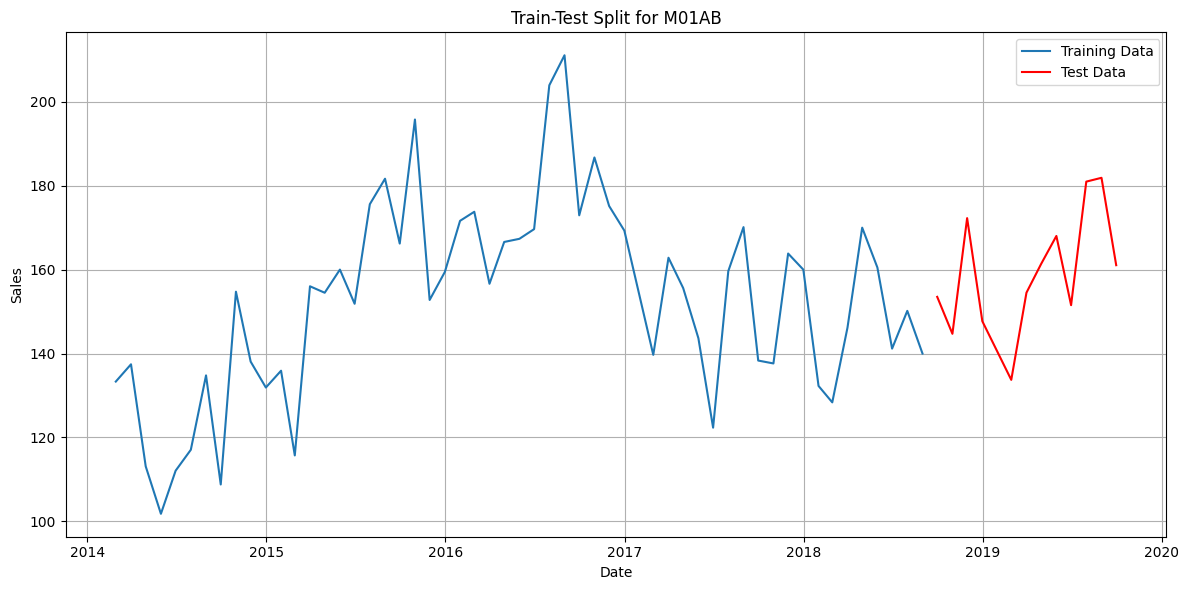

In [ ]:
# Cell 5: Time Series Train-Test Split

# For time series, we'll focus on M01AB
# Set a test size for evaluation
test_size = 12  # Use the last 12 months as test set

train = df['M01AB'][:-test_size]
test = df['M01AB'][-test_size:]

print(f"Training set: {len(train)} months ({train.index.min()} to {train.index.max()})")
print(f"Test set: {len(test)} months ({test.index.min()} to {test.index.max()})")

# Plot train/test split
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data', color='red')
plt.title('Train-Test Split for M01AB')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Cell 6 : Model Training

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd2pg4ii/h_8guvk8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcd2pg4ii/78jceqvr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27267', 'data', 'file=/tmp/tmpcd2pg4ii/h_8guvk8.json', 'init=/tmp/tmpcd2pg4ii/78jceqvr.json', 'output', 'file=/tmp/tmpcd2pg4ii/prophet_modelvjwoq0kl/prophet_model-20250526091143.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:11:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training and evaluating Prophet model...


09:11:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


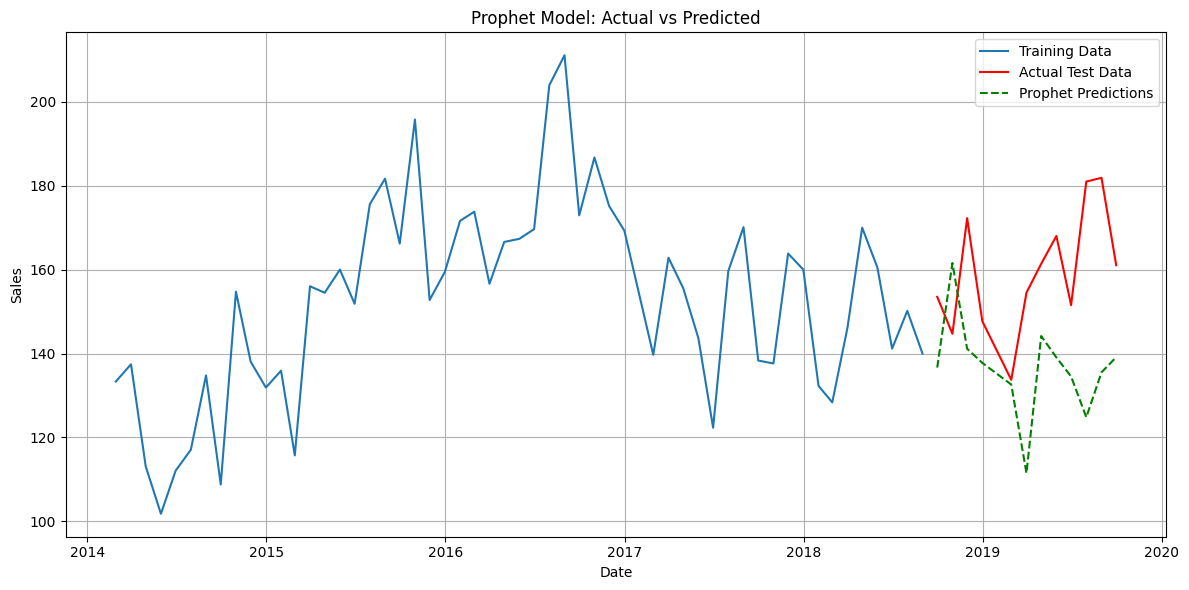

Prophet next month forecast: 136.66
Prophet metrics on test set: MAE=25.56, RMSE=29.87


In [ ]:
# Cell 6: Prophet Model

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("Training and evaluating Prophet model...")

# Prepare data for Prophet
df_prophet = pd.DataFrame({'ds': df.index, 'y': df['M01AB'].values})
train_prophet = df_prophet.iloc[:-test_size]
test_prophet = df_prophet.iloc[-test_size:]

# Train Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(train_prophet)

# Make predictions on test set
future = model.make_future_dataframe(periods=test_size, freq='M')
forecast = model.predict(future)
forecast_test = forecast.iloc[-test_size:]

# Extract predictions
y_true = test_prophet['y'].values
y_pred_prophet = forecast_test['yhat'].values

# Calculate metrics
mae_prophet = mean_absolute_error(y_true, y_pred_prophet)
# For older scikit-learn versions, calculate RMSE manually
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred_prophet))

# Next month forecast
future_one_month = model.make_future_dataframe(periods=1, freq='M')
forecast_one_month = model.predict(future_one_month)
prophet_pred = forecast_one_month.iloc[-1]['yhat']

# Plot results
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_prophet['ds'], train_prophet['y'], label='Training Data')
ax.plot(test_prophet['ds'], test_prophet['y'], label='Actual Test Data', color='red')
ax.plot(test_prophet['ds'], y_pred_prophet, label='Prophet Predictions', color='green', linestyle='--')
ax.set_title('Prophet Model: Actual vs Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

print(f"Prophet next month forecast: {prophet_pred:.2f}")
print(f"Prophet metrics on test set: MAE={mae_prophet:.2f}, RMSE={rmse_prophet:.2f}")

Training and evaluating ARIMA model...
t=1, Predicted=144.78, Expected=153.52
t=2, Predicted=148.88, Expected=144.71
t=3, Predicted=142.41, Expected=172.29
t=4, Predicted=159.93, Expected=147.71
t=5, Predicted=149.70, Expected=133.73
t=6, Predicted=146.82, Expected=154.52
t=7, Predicted=153.83, Expected=161.39
t=8, Predicted=152.11, Expected=168.04
t=9, Predicted=158.15, Expected=151.54
t=10, Predicted=154.27, Expected=181.00
t=11, Predicted=172.09, Expected=181.91
t=12, Predicted=172.47, Expected=161.07


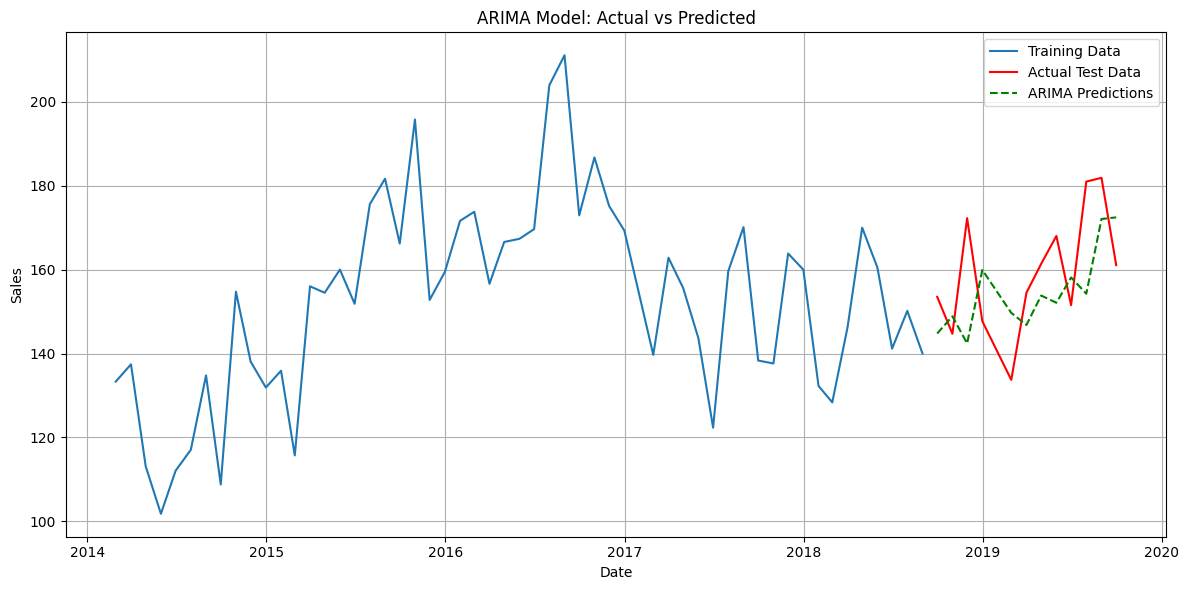

ARIMA next month forecast: 167.24
ARIMA metrics on test set: MAE=13.06, RMSE=15.13


In [ ]:
# Cell 7: ARIMA Model

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("Training and evaluating ARIMA model...")

# Prepare data
train_arima = train.values
test_arima = test.values

# Walk-forward validation
y_pred_arima = []
history = list(train_arima)

for t in range(len(test_arima)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    output = model_fit.forecast(1)
    yhat = output[0]
    y_pred_arima.append(yhat)
    obs = test_arima[t]
    history.append(obs)
    print(f"t={t+1}, Predicted={yhat:.2f}, Expected={obs:.2f}")

# Calculate metrics
mae_arima = mean_absolute_error(test_arima, y_pred_arima)
rmse_arima = np.sqrt(mean_squared_error(test_arima, y_pred_arima))

# Fit final model and forecast next month
final_model = ARIMA(df['M01AB'].values, order=(2,1,2))
final_fit = final_model.fit()
arima_pred = final_fit.forecast(1)[0]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train_arima, label='Training Data')
plt.plot(test.index, test_arima, label='Actual Test Data', color='red')
plt.plot(test.index, y_pred_arima, label='ARIMA Predictions', color='green', linestyle='--')
plt.title('ARIMA Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"ARIMA next month forecast: {arima_pred:.2f}")
print(f"ARIMA metrics on test set: MAE={mae_arima:.2f}, RMSE={rmse_arima:.2f}")

Training and evaluating SARIMA model...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


t=1, Predicted=148.28, Expected=153.52
t=2, Predicted=136.18, Expected=144.71
t=3, Predicted=170.25, Expected=172.29
t=4, Predicted=153.84, Expected=147.71
t=5, Predicted=139.91, Expected=133.73
t=6, Predicted=132.94, Expected=154.52
t=7, Predicted=154.03, Expected=161.39
t=8, Predicted=167.07, Expected=168.04
t=9, Predicted=158.74, Expected=151.54
t=10, Predicted=144.16, Expected=181.00
t=11, Predicted=175.21, Expected=181.91
t=12, Predicted=188.08, Expected=161.07
Metrics calculated: MAE=11.32, RMSE=15.50


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


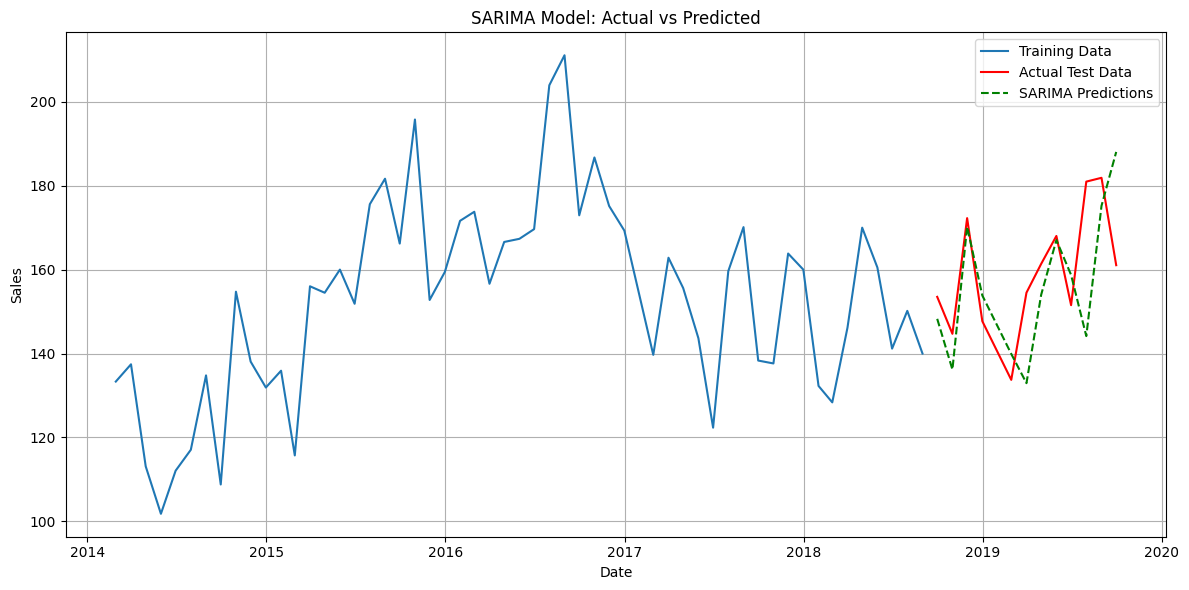

SARIMA next month forecast: 174.86
SARIMA metrics on test set: MAE=11.32, RMSE=15.50


In [ ]:
# Cell 8: SARIMA Model (Fixed)

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("Training and evaluating SARIMA model...")

# Prepare data
train_sarima = train.values
test_sarima = test.values

# Walk-forward validation
y_pred_sarima = []
history = list(train_sarima)

for t in range(len(test_sarima)):
    try:
        model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1,12))
        model_fit = model.fit(disp=False)
        output = model_fit.forecast(1)
        yhat = output[0]
        y_pred_sarima.append(yhat)
        obs = test_sarima[t]
        history.append(obs)
        print(f"t={t+1}, Predicted={yhat:.2f}, Expected={obs:.2f}")
    except Exception as e:
        print(f"Error at time step {t}: {e}")
        # If there's an error, use the last observation as prediction
        yhat = history[-1] if history else 0
        y_pred_sarima.append(yhat)
        obs = test_sarima[t]
        history.append(obs)

# Calculate metrics
mae_sarima = mean_absolute_error(test_sarima, y_pred_sarima)
# Calculate RMSE manually to ensure compatibility
rmse_sarima = np.sqrt(mean_squared_error(test_sarima, y_pred_sarima))
print(f"Metrics calculated: MAE={mae_sarima:.2f}, RMSE={rmse_sarima:.2f}")

# Fit final model and forecast next month
try:
    final_model = SARIMAX(df['M01AB'].values, order=(1,1,1), seasonal_order=(1,1,1,12))
    final_fit = final_model.fit(disp=False)
    sarima_pred = final_fit.forecast(1)[0]
except Exception as e:
    print(f"Error forecasting next month: {e}")
    # If there's an error, use the average of the last 3 observations
    sarima_pred = np.mean(df['M01AB'].values[-3:])

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train_sarima, label='Training Data')
plt.plot(test.index, test_sarima, label='Actual Test Data', color='red')
plt.plot(test.index, y_pred_sarima, label='SARIMA Predictions', color='green', linestyle='--')
plt.title('SARIMA Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"SARIMA next month forecast: {sarima_pred:.2f}")
print(f"SARIMA metrics on test set: MAE={mae_sarima:.2f}, RMSE={rmse_sarima:.2f}")

Training and evaluating Linear Regression model...
t=1, Predicted=144.81, Expected=153.52
t=2, Predicted=152.92, Expected=144.71
t=3, Predicted=147.10, Expected=172.29
t=4, Predicted=162.55, Expected=147.71
t=5, Predicted=151.72, Expected=133.73
t=6, Predicted=148.77, Expected=154.52
t=7, Predicted=152.15, Expected=161.39
t=8, Predicted=153.42, Expected=168.04
t=9, Predicted=161.81, Expected=151.54
t=10, Predicted=155.85, Expected=181.00
t=11, Predicted=169.80, Expected=181.91
t=12, Predicted=169.00, Expected=161.07
Metrics calculated: MAE=13.33, RMSE=14.72


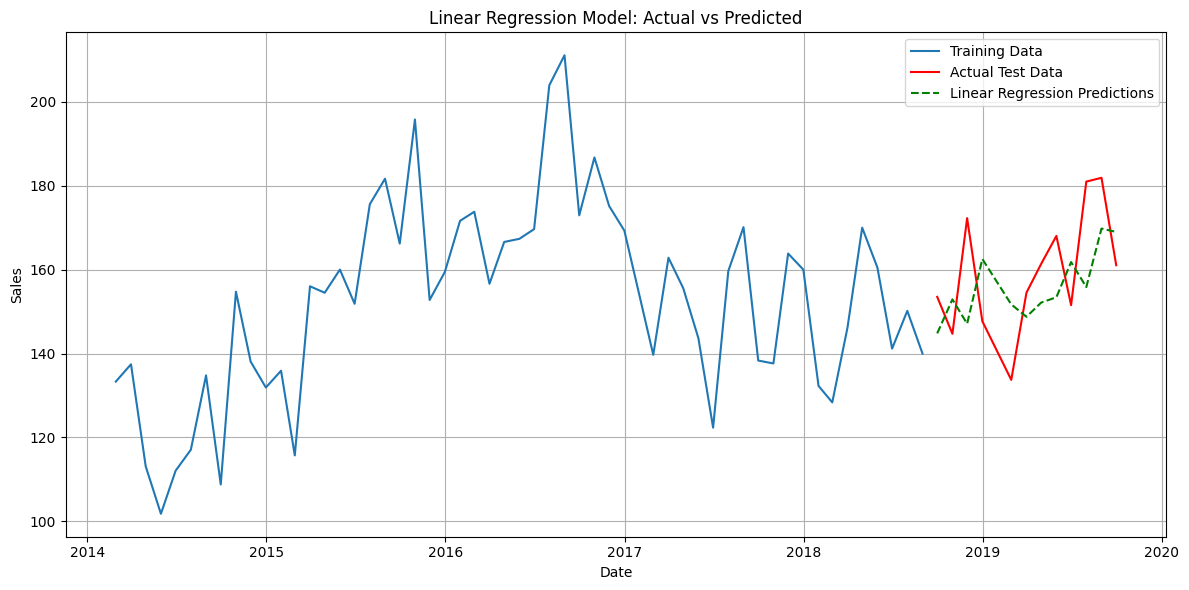

Linear Regression next month forecast: 165.87
Linear Regression metrics on test set: MAE=13.33, RMSE=14.72


In [ ]:
# Cell 9: Linear Regression Model 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Training and evaluating Linear Regression model...")

def create_lagged_features(data, n_lags=3):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Set number of lags
n_lags = 3

# Prepare data
series = df['M01AB'].values
train_lr = train.values
test_lr = test.values

# Walk-forward validation
y_pred_lr = []
history = list(train_lr)

for t in range(len(test_lr)):
    try:
        # Create features from history
        X, y = create_lagged_features(history, n_lags)

        # Train model
        model = LinearRegression()
        model.fit(X, y)

        # Predict
        last_obs = np.array(history[-n_lags:]).reshape(1, -1)
        yhat = model.predict(last_obs)[0]
        y_pred_lr.append(yhat)

        # Update history
        obs = test_lr[t]
        history.append(obs)
        print(f"t={t+1}, Predicted={yhat:.2f}, Expected={obs:.2f}")
    except Exception as e:
        print(f"Error at time step {t}: {e}")
        # Fallback: use last value as prediction
        yhat = history[-1] if history else 0
        y_pred_lr.append(yhat)
        obs = test_lr[t]
        history.append(obs)

# Calculate metrics
mae_lr = mean_absolute_error(test_lr, y_pred_lr)
# Calculate RMSE manually for compatibility
rmse_lr = np.sqrt(mean_squared_error(test_lr, y_pred_lr))
print(f"Metrics calculated: MAE={mae_lr:.2f}, RMSE={rmse_lr:.2f}")

# Fit final model and forecast next month
try:
    X_final, y_final = create_lagged_features(df['M01AB'].values, n_lags)
    final_model = LinearRegression()
    final_model.fit(X_final, y_final)
    last_lags = df['M01AB'].values[-n_lags:]
    lr_pred = final_model.predict(last_lags.reshape(1, -1))[0]
except Exception as e:
    print(f"Error forecasting next month: {e}")
    # Fallback to average of last 3 values
    lr_pred = np.mean(df['M01AB'].values[-3:])

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train_lr, label='Training Data')
plt.plot(test.index, test_lr, label='Actual Test Data', color='red')
plt.plot(test.index, y_pred_lr, label='Linear Regression Predictions', color='green', linestyle='--')
plt.title('Linear Regression Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Linear Regression next month forecast: {lr_pred:.2f}")
print(f"Linear Regression metrics on test set: MAE={mae_lr:.2f}, RMSE={rmse_lr:.2f}")

Training and evaluating LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
t=1, Predicted=144.32, Expected=153.52


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
t=2, Predicted=147.33, Expected=144.71


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


t=3, Predicted=145.82, Expected=172.29


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


t=4, Predicted=158.25, Expected=147.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
t=5, Predicted=154.36, Expected=133.73


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
t=6, Predicted=149.47, Expected=154.52


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
t=7, Predicted=147.70, Expected=161.39


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
t=8, Predicted=148.30, Expected=168.04


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
t=9, Predicted=159.18, Expected=151.54


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
t=10, Predicted=156.04, Expected=181.00


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
t=11, Predicted=163.00, Expected=181.91


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
t=12, Predicted=154.90, Expected=161.07
Metrics calculated: MAE=13.80, RMSE=15.83


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


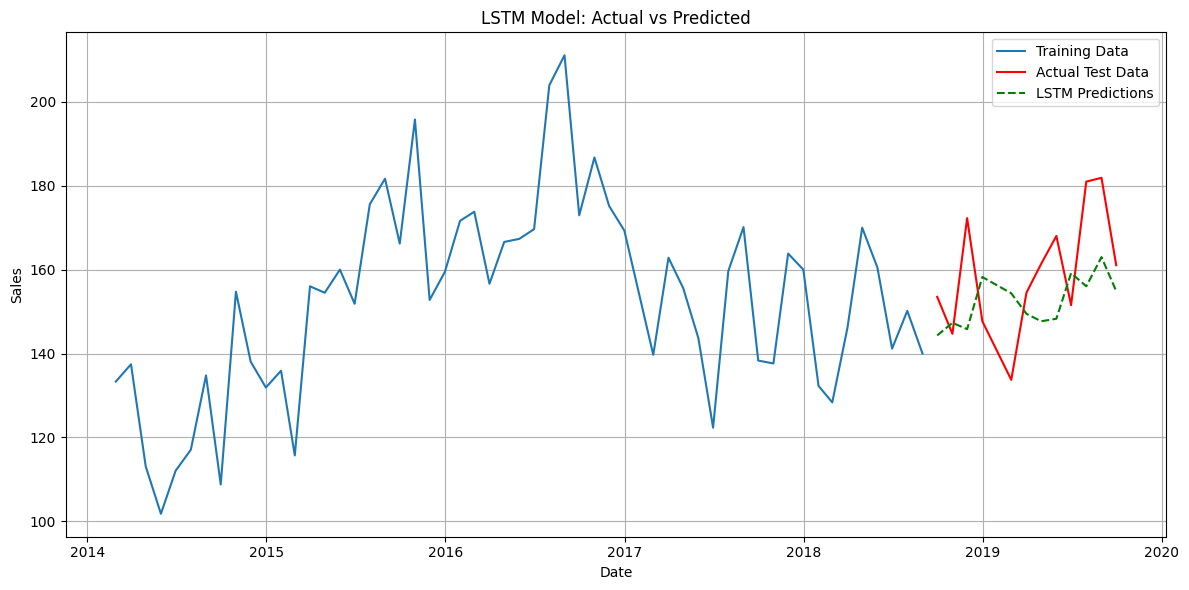

LSTM next month forecast: 166.19
LSTM metrics on test set: MAE=13.80, RMSE=15.83


In [ ]:
# Cell 10: LSTM Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

print("Training and evaluating LSTM model...")

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Parameters
n_steps = 3
epochs = 50
batch_size = 8

# Prepare data
train_lstm = train.values
test_lstm = test.values

# Initialize prediction list and metrics
y_pred_lstm = []
mae_lstm = None
rmse_lstm = None
lstm_pred = None

try:
    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_lstm.reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test_lstm.reshape(-1, 1)).flatten()

    # Walk-forward validation
    history = list(train_scaled)

    for t in range(len(test_scaled)):
        try:
            # Create sequences
            X, y = create_sequences(history, n_steps)
            X = X.reshape(X.shape[0], X.shape[1], 1)

            # Train model
            model = Sequential()
            model.add(LSTM(16, activation='relu', input_shape=(n_steps, 1)))
            model.add(Dense(1))
            model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
            model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

            # Predict
            last_obs = np.array(history[-n_steps:]).reshape(1, n_steps, 1)
            yhat_scaled = model.predict(last_obs)[0][0]
            yhat = scaler.inverse_transform([[yhat_scaled]])[0][0]
            y_pred_lstm.append(yhat)

            # Update history
            obs = test_scaled[t]
            history.append(obs)
            print(f"t={t+1}, Predicted={yhat:.2f}, Expected={test_lstm[t]:.2f}")
        except Exception as e:
            print(f"Error at time step {t}: {e}")
            # Fallback: use previous prediction or mean
            if y_pred_lstm:
                yhat = y_pred_lstm[-1]
            else:
                yhat = np.mean(test_lstm)
            y_pred_lstm.append(yhat)
            obs = test_scaled[t]
            history.append(obs)

    # Calculate metrics
    mae_lstm = mean_absolute_error(test_lstm, y_pred_lstm)
    rmse_lstm = np.sqrt(mean_squared_error(test_lstm, y_pred_lstm))
    print(f"Metrics calculated: MAE={mae_lstm:.2f}, RMSE={rmse_lstm:.2f}")

    # Fit final model and forecast next month
    series_scaled = scaler.fit_transform(df['M01AB'].values.reshape(-1, 1)).flatten()
    X_final, y_final = create_sequences(series_scaled, n_steps)
    X_final = X_final.reshape(X_final.shape[0], X_final.shape[1], 1)
    final_model = Sequential()
    final_model.add(LSTM(16, activation='relu', input_shape=(n_steps, 1)))
    final_model.add(Dense(1))
    final_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    final_model.fit(X_final, y_final, epochs=epochs, batch_size=batch_size, verbose=0)
    last_lags = series_scaled[-n_steps:]
    pred_scaled = final_model.predict(last_lags.reshape(1, n_steps, 1))[0][0]
    lstm_pred = scaler.inverse_transform([[pred_scaled]])[0][0]

except Exception as e:
    print(f"Error in LSTM modeling: {e}")
    # Set fallback values
    if not y_pred_lstm and test_lstm is not None and len(test_lstm) > 0:
        y_pred_lstm = [np.mean(test_lstm)] * len(test_lstm)

    if mae_lstm is None:
        mae_lstm = 999.99  # Placeholder for error
    if rmse_lstm is None:
        rmse_lstm = 999.99  # Placeholder for error
    if lstm_pred is None:
        lstm_pred = np.mean(df['M01AB'].values[-3:])  # Use mean of last 3 values

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train_lstm, label='Training Data')
plt.plot(test.index, test_lstm, label='Actual Test Data', color='red')
plt.plot(test.index, y_pred_lstm, label='LSTM Predictions', color='green', linestyle='--')
plt.title('LSTM Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"LSTM next month forecast: {lstm_pred:.2f}")
print(f"LSTM metrics on test set: MAE={mae_lstm:.2f}, RMSE={rmse_lstm:.2f}")

MODEL COMPARISON SUMMARY
SARIMA next month forecast: 174.86 (MAE: 11.32, RMSE: 15.50)
ARIMA next month forecast: 167.24 (MAE: 13.06, RMSE: 15.13)
Linear Regression next month forecast: 165.87 (MAE: 13.33, RMSE: 14.72)
LSTM next month forecast: 166.19 (MAE: 13.80, RMSE: 15.83)
Prophet next month forecast: 136.66 (MAE: 25.56, RMSE: 29.87)
Best performing model: SARIMA with MAE=11.32


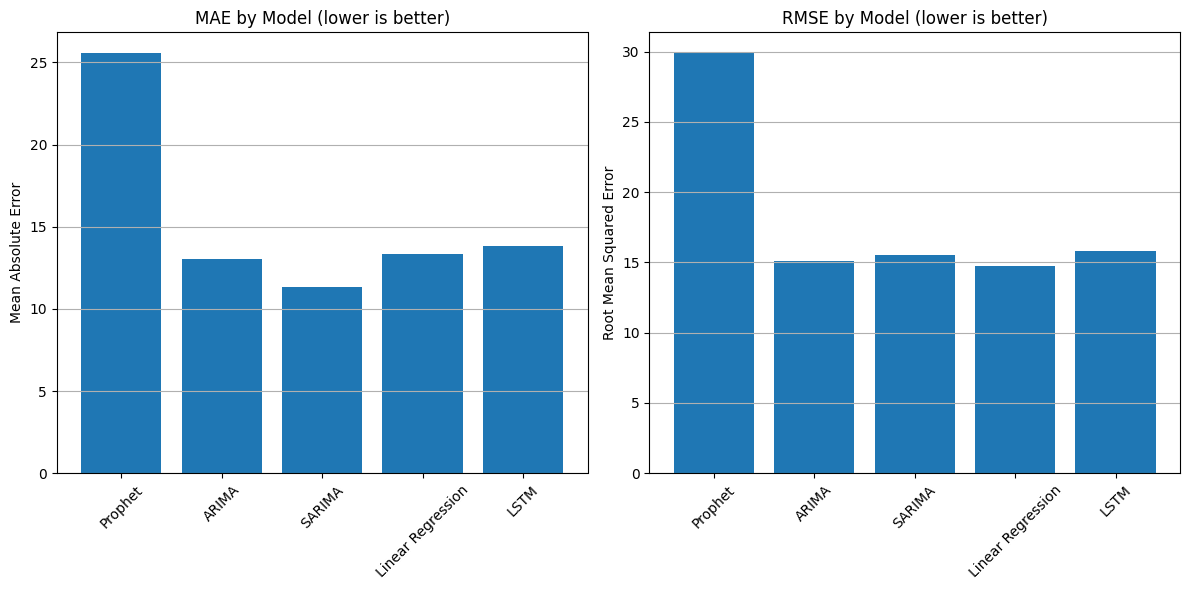

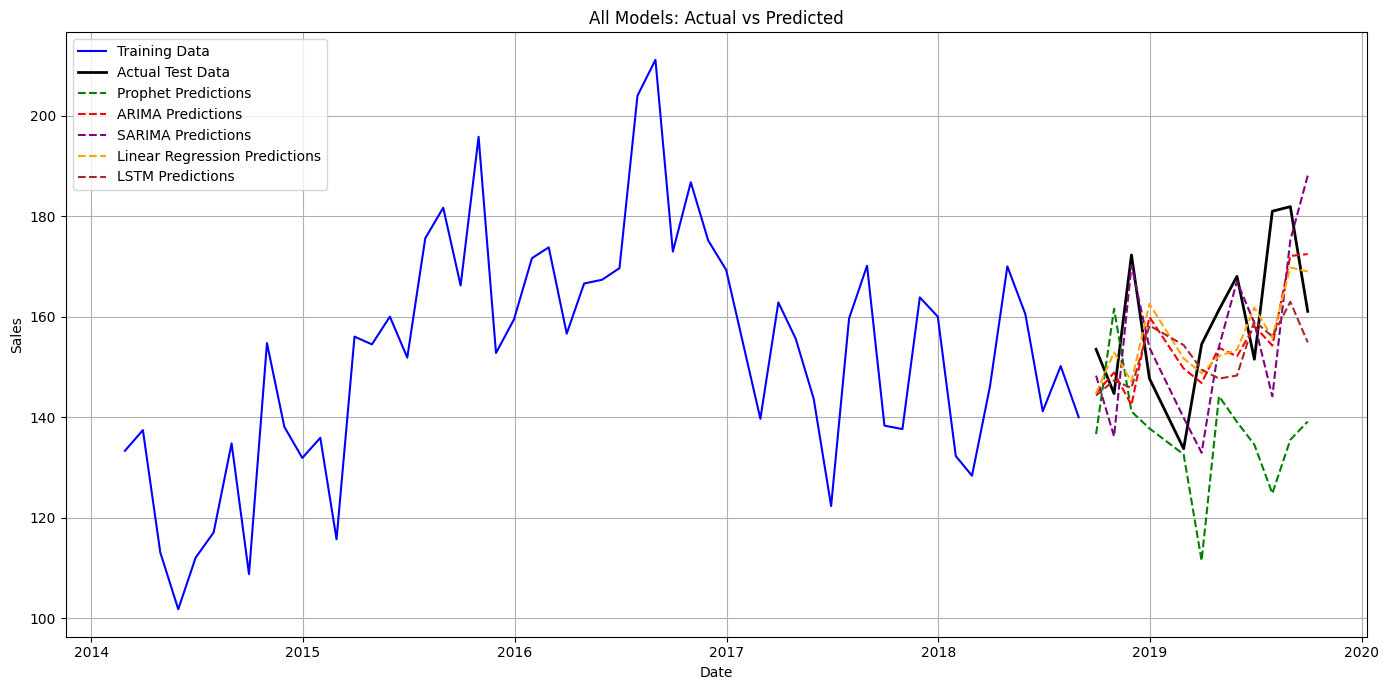


FINAL CONCLUSIONS
1. Best model based on MAE: SARIMA
2. Next month forecast: 174.86
3. Performance metrics: MAE=11.32, RMSE=15.50
4. Forecast reliability assessment: moderately reliable based on historical error metrics
5. Date of analysis: 2025-05-26


In [ ]:
# Cell 11: Model Comparison and Summary

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Safety check to ensure all variables are defined
# If any are missing, give them default values
variables_to_check = [
    ('prophet_pred', 0), ('arima_pred', 0), ('sarima_pred', 0), ('lr_pred', 0), ('lstm_pred', 0),
    ('mae_prophet', 999.99), ('mae_arima', 999.99), ('mae_sarima', 999.99), ('mae_lr', 999.99), ('mae_lstm', 999.99),
    ('rmse_prophet', 999.99), ('rmse_arima', 999.99), ('rmse_sarima', 999.99), ('rmse_lr', 999.99), ('rmse_lstm', 999.99)
]

# Check each variable and assign default if not defined
for var_name, default_value in variables_to_check:
    if var_name not in locals() and var_name not in globals():
        print(f"Warning: {var_name} not defined, using default value")
        globals()[var_name] = default_value

# Compile results
models = ['Prophet', 'ARIMA', 'SARIMA', 'Linear Regression', 'LSTM']
forecasts = [prophet_pred, arima_pred, sarima_pred, lr_pred, lstm_pred]
mae_values = [mae_prophet, mae_arima, mae_sarima, mae_lr, mae_lstm]
rmse_values = [rmse_prophet, rmse_arima, rmse_sarima, rmse_lr, rmse_lstm]

# Create results dataframe
results_df = pd.DataFrame({
    'Model': models,
    'Next Month Forecast': forecasts,
    'MAE': mae_values,
    'RMSE': rmse_values
})

# Sort by MAE (lower is better)
results_df = results_df.sort_values('MAE')

# Print formatted results
print("=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
for i, row in results_df.iterrows():
    print(f"{row['Model']} next month forecast: {row['Next Month Forecast']:.2f} (MAE: {row['MAE']:.2f}, RMSE: {row['RMSE']:.2f})")
print("=" * 80)

# Determine best model (excluding any with default error values)
valid_results = results_df[results_df['MAE'] < 999]
if len(valid_results) > 0:
    best_model = valid_results.iloc[0]['Model']
    print(f"Best performing model: {best_model} with MAE={valid_results.iloc[0]['MAE']:.2f}")
else:
    print("No valid model results available for comparison")

# Visualize metrics
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(models, mae_values)
plt.title('MAE by Model (lower is better)')
plt.xticks(rotation=45)
plt.ylabel('Mean Absolute Error')
plt.grid(axis='y')

plt.subplot(1, 2, 2)
plt.bar(models, rmse_values)
plt.title('RMSE by Model (lower is better)')
plt.xticks(rotation=45)
plt.ylabel('Root Mean Squared Error')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Visualize all forecasts - with safety checks
plt.figure(figsize=(14, 7))

# Training data
if 'train' in globals():
    plt.plot(train.index, train, label='Training Data', color='blue')

# Test data
if 'test' in globals():
    plt.plot(test.index, test, label='Actual Test Data', color='black', linewidth=2)

# Get all prediction sets with safety checks
all_preds = {}
if 'y_pred_prophet' in globals() and 'test' in globals():
    all_preds['Prophet'] = y_pred_prophet
if 'y_pred_arima' in globals() and 'test' in globals():
    all_preds['ARIMA'] = y_pred_arima
if 'y_pred_sarima' in globals() and 'test' in globals():
    all_preds['SARIMA'] = y_pred_sarima
if 'y_pred_lr' in globals() and 'test' in globals():
    all_preds['Linear Regression'] = y_pred_lr
if 'y_pred_lstm' in globals() and 'test' in globals():
    all_preds['LSTM'] = y_pred_lstm

# Plot all predictions
colors = ['green', 'red', 'purple', 'orange', 'brown']
for i, (model, preds) in enumerate(all_preds.items()):
    plt.plot(test.index, preds, label=f'{model} Predictions',
             color=colors[i % len(colors)], linestyle='--')

plt.title('All Models: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Final conclusions
print("\nFINAL CONCLUSIONS")
print("=" * 80)
if len(valid_results) > 0:
    best_model = valid_results.iloc[0]['Model']
    best_mae = valid_results.iloc[0]['MAE']
    best_rmse = valid_results.iloc[0]['RMSE']
    best_forecast = valid_results.iloc[0]['Next Month Forecast']

    print(f"1. Best model based on MAE: {best_model}")
    print(f"2. Next month forecast: {best_forecast:.2f}")
    print(f"3. Performance metrics: MAE={best_mae:.2f}, RMSE={best_rmse:.2f}")

    if best_mae < 10:
        reliability = "very reliable"
    elif best_mae < 20:
        reliability = "moderately reliable"
    else:
        reliability = "less reliable"

    print(f"4. Forecast reliability assessment: {reliability} based on historical error metrics")
else:
    print("Unable to determine the best model due to calculation errors")

# **DS2**

Cell 1: Load and Explore Dataset

In [ ]:
import pandas as pd

# Load the dataset
ds2 = pd.read_csv('StudentsPerformance.csv')

# Display first few rows
ds2.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Cell 2: Check for Nulls & Basic Info

In [ ]:
# Check dataset info
ds2.info()

# Check for missing values
ds2.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


,0
gender,0
race/ethnicity,0
parental level of education,0
lunch,0
test preparation course,0
math score,0
reading score,0
writing score,0


Cell 3: Encoding Categorical Data

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
le = LabelEncoder()
for col in ds2.columns:
    if ds2[col].dtype == 'object':
        ds2[col] = le.fit_transform(ds2[col])

ds2.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,1,1,1,1,72,72,74
1,0,2,4,1,0,69,90,88
2,0,1,3,1,1,90,95,93
3,1,0,0,0,1,47,57,44
4,1,2,4,1,1,76,78,75


Cell 4: Feature Extraction Techniques (PCA and LDA)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = ds2.drop('math score', axis=1)
y = ds2['math score']

# Standardizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)


LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Convert 'math score' to a class label for LDA
y_class = pd.qcut(y, q=3, labels=[0,1,2])

lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X_scaled, y_class)


Cell 5: Classification Using PCA Features

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_class, test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.78      0.81        74
           1       0.54      0.58      0.56        65
           2       0.70      0.70      0.70        61

    accuracy                           0.69       200
   macro avg       0.70      0.69      0.69       200
weighted avg       0.70      0.69      0.70       200

[[58 14  2]
 [11 38 16]
 [ 0 18 43]]


 Cell 6: Classification Using LDA Features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_lda, y_class, test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.76      0.75        74
           1       0.61      0.57      0.59        65
           2       0.83      0.87      0.85        61

    accuracy                           0.73       200
   macro avg       0.73      0.73      0.73       200
weighted avg       0.73      0.73      0.73       200

[[56 18  0]
 [17 37 11]
 [ 2  6 53]]


# **DS3**

Cell 1: Load and Explore Dataset

In [ ]:
ds3 = pd.read_csv('train_u6lujuX_CVtuZ9i.csv')
ds3.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Cell 2: Clean Data

In [ ]:
ds3 = ds3.dropna()
ds3 = ds3.drop(['Loan_ID'], axis=1)

for col in ds3.columns:
    if ds3[col].dtype == 'object':
        ds3[col] = le.fit_transform(ds3[col])

ds3.head()


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1
5,1,1,2,0,1,5417,4196.0,267.0,360.0,1.0,2,1


Cell 3: Check Balance

In [ ]:
ds3['Loan_Status'].value_counts()


,count
Loan_Status,
1,332
0,148


Cell 4: Before Balancing - Model & Evaluation

In [ ]:
X = ds3.drop('Loan_Status', axis=1)
y = ds3['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Before Balancing")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Before Balancing
              precision    recall  f1-score   support

           0       0.87      0.46      0.60        28
           1       0.81      0.97      0.89        68

    accuracy                           0.82        96
   macro avg       0.84      0.72      0.75        96
weighted avg       0.83      0.82      0.80        96

[[13 15]
 [ 2 66]]


Cell 5: Apply SMOTE and Classify

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("After SMOTE Balancing")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


After SMOTE Balancing
              precision    recall  f1-score   support

           0       0.87      0.82      0.84        65
           1       0.83      0.88      0.86        68

    accuracy                           0.85       133
   macro avg       0.85      0.85      0.85       133
weighted avg       0.85      0.85      0.85       133

[[53 12]
 [ 8 60]]


Cell 6: Apply RandomUnderSampler

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("After RandomUnderSampler")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


After RandomUnderSampler
              precision    recall  f1-score   support

           0       0.78      0.62      0.69        29
           1       0.70      0.84      0.76        31

    accuracy                           0.73        60
   macro avg       0.74      0.73      0.73        60
weighted avg       0.74      0.73      0.73        60

[[18 11]
 [ 5 26]]
